<a href="https://colab.research.google.com/github/maciejskorski/jitter-transfer/blob/main/JitterTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical experiments

* the first experiment compares the true and approximated phase of a ring oscillator sampled with another ring
* the second experiment studies the approximation error in relation to the jitter level

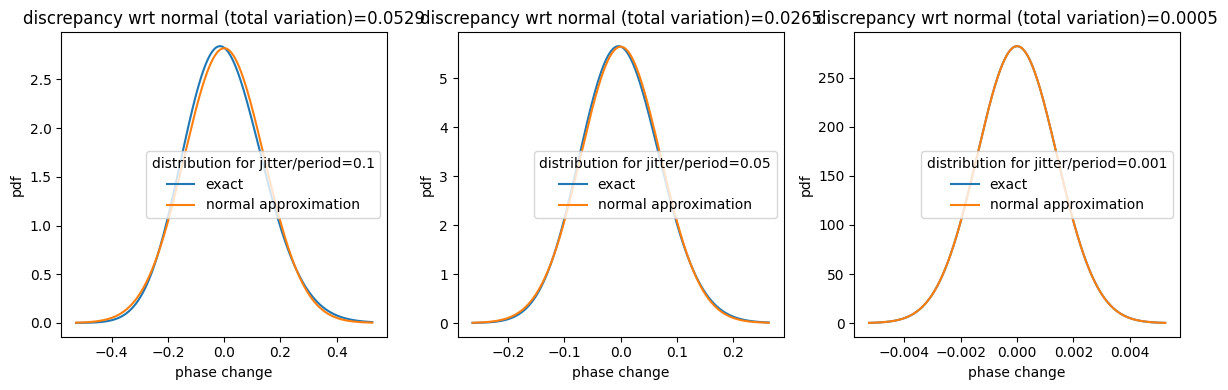

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norminvgauss
from scipy.stats import norm
import scipy.special as sc
from scipy.stats._continuous_distns import norminvgauss_gen
import pandas as pd
import seaborn as sns

def norminvgauss_pdf(self,x,a,b):
  # a numerically stable version of https://github.com/scipy/scipy/blob/v1.11.4/scipy/stats/_continuous_distns.py#L4930-L5074↪→
  gamma = np.sqrt(a**2 - b**2)
  fac1 = a / np.pi #* np.exp(gamma)
  sq = np.hypot(1, x) # reduce overflows
  return fac1 * sc.k1e(a * sq) * np.exp(b*x - a*sq + gamma) / sq


norminvgauss_gen._pdf = norminvgauss_pdf
fig,axs = plt.subplots(1,3,figsize=(12,4))

for ax,jitter in zip(axs,[0.1,0.05,0.001]):
  scale = 1
  Z = norminvgauss(2**0.5/jitter**2,1/jitter**2,loc=0,scale=scale)
  Z_approx = norm(Z.mean(),Z.std())
  x_min,x_max = Z_approx.ppf(0.0001),Z_approx.ppf(0.9999)
  xs = np.linspace(x_min,x_max,10000)
  pdf1 = Z.pdf(xs*scale)
  pdf2 = Z_approx.pdf(xs*scale)
  discrepancy = np.abs(pdf1-pdf2).mean()*(x_max-x_min)
  pd.DataFrame({'phase':xs-1,'pdf_exact':pdf1,'pdf_approx':pdf2}).iloc[::10,:].to_csv(f'discrepancy_{jitter:.3f}.csv')
  ax.plot(xs-1, pdf1,label='exact')
  ax.plot(xs-1, pdf2,label='normal approximation')
  ax.set_xlabel('phase change')
  ax.set_ylabel('pdf')
  ax.legend(title=f"distribution for jitter/period={jitter}")
  ax.set_title(f'discrepancy wrt normal (total variation)={discrepancy:.4f}')

plt.tight_layout()
plt.show()

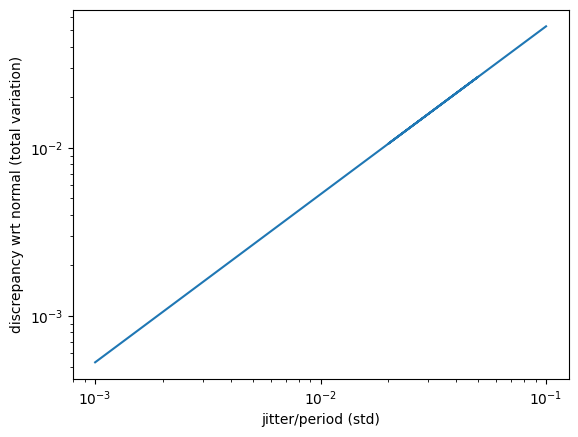

In [2]:
outs = []
for jitter in [0.1,0.02,0.05,0.01,0.005,0.002,0.001]:
  Z = norminvgauss(2**0.5/jitter**2,1/jitter**2,loc=0,scale=1)
  Z_approx = norm(Z.mean(),Z.std())
  x_min,x_max = Z_approx.ppf(0.0001),Z_approx.ppf(0.9999)
  xs = np.linspace(x_min,x_max,10000)
  pdf1 = Z.pdf(xs*scale)
  pdf2 = Z_approx.pdf(xs*scale)
  discrepancy = np.abs(pdf1-pdf2).mean()*(x_max-x_min)
  outs.append( (jitter,discrepancy ))

fig,ax = plt.subplots()
ax.plot(*zip(*outs))

ax.set_xlabel("jitter/period (std)")
ax.set_xscale("log")
ax.set_ylabel("discrepancy wrt normal (total variation)")
ax.set_yscale("log")
plt.show()

pd.DataFrame(outs,columns=['jitter','discrepancy']).to_csv("jitter_discrepancy.csv")